# 0. LIBRERIAS



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CARGA DE DATASET

In [4]:
df1 = pd.read_excel('/content/df_2012_preproc_10s.xlsx', index_col="timestamp")
df2 = pd.read_excel('/content/df_2014_preproc_10s.xlsx', index_col="timestamp")
df3 = pd.read_excel('/content/df_2015_preproc_10s.xlsx', index_col="timestamp")

In [5]:
df_train = pd.concat([df1, df2], axis = 0)
df_test = df3

In [6]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [7]:

# import the libraries
import tensorflow as tf
import pandas as pd
from sklearn.compose import ColumnTransformer

#from scikeras.wrappers import KerasClassifier # Corrected import
from sklearn.model_selection import GridSearchCV


In [8]:
from keras import backend as K

In [9]:
K.clear_session()

In [10]:
tf.keras.utils.set_random_seed(1809)

In [11]:
# Datos
X_train = df_train.drop(columns=['class'])
y_train = df_train['class']
X_test = df_test.drop(columns=['class'])
y_test = df_test['class']

num_features = X_train.shape[1]
num_classes = 3

In [12]:
#Escalado
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [13]:
y_train = y_train.map({'Normal': 0, 'Transitorio': 1, 'Falla': 2})
y_test = y_test.map({'Normal': 0, 'Transitorio': 1, 'Falla': 2})

In [14]:
from sklearn.model_selection import train_test_split
X_tt_train, X_tt_val, y_tt_train, y_tt_val = train_test_split(X_train_sc, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [15]:
one_hot_y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)

In [16]:
one_hot_y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [17]:
one_hot_y_tt_train = tf.keras.utils.to_categorical(y_tt_train, num_classes=3)
one_hot_y_tt_val = tf.keras.utils.to_categorical(y_tt_val, num_classes=3)

In [18]:
import tensorflow as tf

class SpecificClassFPTP(tf.keras.metrics.Metric):

  def __init__(self, class_id, name='specific_class_fptp', **kwargs):
    super().__init__(name=name, **kwargs)
    self.class_id = class_id
    self.true_positives = self.add_weight(name='tp', initializer='zeros')
    self.false_positives = self.add_weight(name='fp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    # Convert predictions to binary (0 or 1) for the target class
    y_pred_binary = tf.cast(tf.argmax(y_pred, axis=-1) == self.class_id, tf.float32)
    y_true_binary = tf.cast(tf.argmax(y_true, axis=-1) == self.class_id, tf.float32)

    # Calculate true positives for the specific class
    p_batch = tf.reduce_sum(y_true_binary * y_pred_binary)
    self.true_positives.assign_add(p_batch) # Corrected variable name

    # Calculate false positives for the specific class
    # FP occurs when y_true is 0 for this class, but y_pred is 1 for this class
    fp_batch = tf.reduce_sum((1 - y_true_binary) * y_pred_binary)
    self.false_positives.assign_add(fp_batch)

  def result(self):
    return 15*self.true_positives -2*self.false_positives # Corrected variable name

  def reset_state(self):
    self.true_positives.assign(0.0)
    self.false_positives.assign(0.0)

METRICS = [SpecificClassFPTP(class_id=1)]

In [19]:
from sklearn.model_selection import ParameterSampler

hyperparameter_space = {'units': np.arange(20,60,10),'activation': ['relu', 'sigmoid'],'batch_size':[16,32,64]}
hyperparameters = list(ParameterSampler(hyperparameter_space,n_iter=10, random_state = 1809))

In [20]:
hyperparameters

[{'units': np.int64(50), 'batch_size': 64, 'activation': 'sigmoid'},
 {'units': np.int64(30), 'batch_size': 16, 'activation': 'relu'},
 {'units': np.int64(30), 'batch_size': 16, 'activation': 'sigmoid'},
 {'units': np.int64(40), 'batch_size': 64, 'activation': 'sigmoid'},
 {'units': np.int64(50), 'batch_size': 32, 'activation': 'relu'},
 {'units': np.int64(30), 'batch_size': 64, 'activation': 'relu'},
 {'units': np.int64(20), 'batch_size': 32, 'activation': 'sigmoid'},
 {'units': np.int64(20), 'batch_size': 16, 'activation': 'relu'},
 {'units': np.int64(30), 'batch_size': 32, 'activation': 'sigmoid'},
 {'units': np.int64(40), 'batch_size': 32, 'activation': 'relu'}]

In [21]:
def entrenar_modelo(hparams):
  mlp_model = Sequential() # Create a new model here
  mlp_model.add(Input(shape=(num_features,)))# input
  mlp_model.add(Dense(units=hparams['units'],  activation=hparams['activation'])) #first hidden layer
  mlp_model.add(Dense(units=num_classes, activation='softmax')) # output layer
  #layer_in = tfkl.Input(shape=(28,28)) #Todo modelo necesita una entrada, y debemos especificar sus dimensiones
  #Esta capa rompe la estructura de imagen y nos deja un vector (1x784)
  #flatten_layer = tfkl.Flatten()(layer_in)
  #Esta es la capa de salida
  #hidden_layer = tfkl.Dense(units=hparams['units'], activation=hparams['activation'])(flatten_layer)
  #Esta es la capa de salida:
  #output_layer = tfkl.Dense(units=10,activation='softmax')(hidden_layer)

  #mlp_model = tf.keras.Model(inputs=[layer_in],outputs=[output_layer])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  #metrics_list = [tf.keras.metrics.CategoricalAccuracy(),
  #                tf.keras.metrics.Precision(),
  #                tf.keras.metrics.Recall(),
  #                tf.keras.metrics.AUC()]
  metric_names = ['loss', 'specific_class_fptp'] # Update metric_names to include the custom metric
  mlp_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=METRICS)

  cb_list = [tf.keras.callbacks.TensorBoard(log_dir='tblogs'),
              tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints.keras'),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]

  mlp_model.fit(x=X_tt_train,y=one_hot_y_tt_train,validation_data=(X_tt_val,one_hot_y_tt_val),batch_size=hparams['batch_size'],epochs=10,callbacks=cb_list)
  performance = mlp_model.evaluate(x=X_tt_val,y=one_hot_y_tt_val) # Use model instead of mlp_model
  performance = dict(zip(metric_names,performance))

  return mlp_model, performance, hparams # Use model instead of mlp_model

In [22]:
best_metric = 0
#best_metric = -float('inf') # Initialize with a very low value
best_model = None
best_params = None
hyp_results = []
for hparam in hyperparameters:
  model, perf, hparams = entrenar_modelo(hparam)
  if perf['specific_class_fptp'] > best_metric: # Compare the specific metric
    best_metric = perf['specific_class_fptp']
    best_model = model
    best_params = hparams
  hyp_results.append({'params': hparams,'performance': perf})

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6952 - specific_class_fptp: 183977.6875 - val_loss: 0.2387 - val_specific_class_fptp: 104626.0000
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2057 - specific_class_fptp: 212713.7500 - val_loss: 0.1417 - val_specific_class_fptp: 108678.0000
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1245 - specific_class_fptp: 219813.8438 - val_loss: 0.0970 - val_specific_class_fptp: 110714.0000
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0850 - specific_class_fptp: 223188.4062 - val_loss: 0.0716 - val_specific_class_fptp: 111951.0000
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0620 - specific_class_fptp: 225111.2031 - val_loss: 0.0554 - val_specific_class_fptp: 112634.0000
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0473 - specific_class_fptp: 226066.2656 - val_loss: 0.0448 - val_specific_class_fptp: 112863.0000
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 

In [23]:
best_metric

113257.0

In [24]:
best_params

{'units': np.int64(30), 'batch_size': 16, 'activation': 'relu'}

In [25]:
model = Sequential()

In [26]:
model.add(Input(shape=(num_features,)))# input
model.add(Dense(units=30, activation='relu')) #first hidden layer
#model.add(Dense(units=32, activation='relu')) #Second hidden layer
model.add(Dense(units=num_classes, activation='softmax')) # output layer

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=METRICS)

In [28]:
model.fit(x=X_train_sc,y=one_hot_y_train,batch_size=16,epochs=10)

Epoch 1/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2017 - specific_class_fptp: 387710.2812
Epoch 2/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0223 - specific_class_fptp: 282436.7812
Epoch 3/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0132 - specific_class_fptp: 282668.0000
Epoch 4/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0094 - specific_class_fptp: 282842.2500
Epoch 5/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0072 - specific_class_fptp: 282963.8438
Epoch 6/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0060 - specific_class_fptp: 283040.1250
Epoch 7/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0053 - specific_class_fptp: 283096.8125
Epoch 8/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0049 - specific_class_fptp: 283129.3125
Epoch 9/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0046 - specific_class_fptp: 283132.3438
Epoch 10/10
3441/3441 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - los

In [29]:
y_predicted_train = model.predict(X_train_sc)

1721/1721 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [30]:
y_predicted_test = model.predict(X_test_sc)

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [31]:
loss, gain = model.evaluate(X_train_sc, one_hot_y_train)
print(f"Test Loss: {loss:.4f}, Train metric: {gain:.4f}")

1721/1721 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0012 - specific_class_fptp: 222999.1719
Test Loss: 0.0038, Train metric: 566862.0000


In [32]:
loss, gain = model.evaluate(X_test_sc, one_hot_y_test)
print(f"Test Loss: {loss:.4f}, Train metric: {gain:.4f}")

513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1051 - specific_class_fptp: 54528.6992
Test Loss: 0.6051, Train metric: 159714.0000


In [33]:
from sklearn.metrics import confusion_matrix, make_scorer

In [34]:
#Métricas en train
y_true = y_train
y_pred_probs = y_predicted_train # Rename for clarity

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

def custom_score(y_true, y_pred):
  # Ensure labels are integers for confusion_matrix
  y_true = y_true.astype(int)
  y_pred = y_pred.astype(int)

  NN, NT, NF, TN, TT, TF, FN, FT, FF = confusion_matrix(y_true, y_pred, labels=[0, 1, 2]).ravel()

  gan = 15*TT -2*NT-2*FT #high is good

  F1_T = (2*TT) / (2*TT + NT + FT + TN + TF) # F1-score p transitorio
  Acc = (NN+TT+FF)/(NN+NT+NF+TN+TT+TF+FN+FT+FF) # Accuracy global

  FPR = (NT+FT) / (NN+NT+NF+FN+FT+FF) # False Positive Rate

  Prec_T = TT / (NT + TT + FT) #Precision

  Recall_T = TT / (TN + TT + TF) #Recall

  return gan, F1_T, Acc, FPR, Prec_T, Recall_T

gan, F1_T, Acc, FPR, Prec_T, Recall_T = custom_score(y_true, y_pred)
print("Ganancia: ", gan)
print("F1_score_transitorio: ", round(F1_T,5))
print("Accuracy: ", round(Acc,5))
print("FPR: ", round(FPR,5))
print("Precision: ", round(Prec_T,5))
print("Recall: ", round(Recall_T,5))

Ganancia:  566862
F1_score_transitorio:  0.99959
Accuracy:  0.99944
FPR:  0.00139
Precision:  0.99937
Recall:  0.99981


In [35]:
#Métricas en test
y_true = y_test
y_pred_probs = y_predicted_test # Rename for clarity

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

def custom_score(y_true, y_pred):
  # Ensure labels are integers for confusion_matrix
  y_true = y_true.astype(int)
  y_pred = y_pred.astype(int)

  NN, NT, NF, TN, TT, TF, FN, FT, FF = confusion_matrix(y_true, y_pred, labels=[0, 1, 2]).ravel()

  gan = 15*TT -2*NT-2*FT #high is good

  F1_T = (2*TT) / (2*TT + NT + FT + TN + TF) # F1-score p transitorio
  Acc = (NN+TT+FF)/(NN+NT+NF+TN+TT+TF+FN+FT+FF) # Accuracy global

  FPR = (NT+FT) / (NN+NT+NF+FN+FT+FF) # False Positive Rate

  Prec_T = TT / (NT + TT + FT) #Precision

  Recall_T = TT / (TN + TT + TF) #Recall

  return gan, F1_T, Acc, FPR, Prec_T, Recall_T

gan, F1_T, Acc, FPR, Prec_T, Recall_T = custom_score(y_true, y_pred)
print("Ganancia: ", gan)
print("F1_score_transitorio: ", round(F1_T,5))
print("Accuracy: ", round(Acc,5))
print("FPR: ", round(FPR,5))
print("Precision: ", round(Prec_T,5))
print("Recall: ", round(Recall_T,5))

Ganancia:  159714
F1_score_transitorio:  0.97783
Accuracy:  0.97049
FPR:  0.03905
Precision:  0.98044
Recall:  0.97524


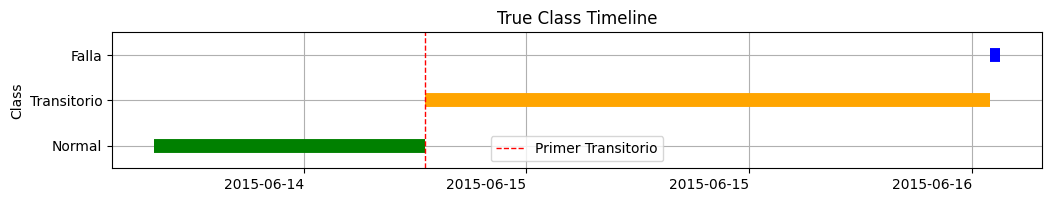

In [36]:
#timeline in true test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates # Import mdates for date formatting

# Map categorical labels to numerical values
y_test_series = pd.Series(y_test, index=y_test.index)
y_num = y_test_series # y_test is already mapped to numerical values

# Drop NaN values from y_num
y_num = y_num.dropna()


# Identify where the class changes
class_changes = y_num[y_num.diff() != 0]

# Create segments
segments = []
if not class_changes.empty:
    # First segment starts at the beginning of the series
    segments.append({'start': y_num.index[0], 'end': class_changes.index[0], 'class': y_num.iloc[0]})

    # Intermediate segments
    for i in range(len(class_changes) - 1):
        segments.append({
            'start': class_changes.index[i],
            'end': class_changes.index[i+1],
            'class': class_changes.iloc[i]
        })

    # Last segment starts at the last change point and ends at the end of the series
    segments.append({'start': class_changes.index[-1], 'end': y_num.index[-1], 'class': class_changes.iloc[-1]}) # Corrected variable name: class_changes.iloc[-1]
else:
    # If no class changes, the whole series is one segment
    if not y_num.empty:
        segments.append({'start': y_num.index[0], 'end': y_num.index[-1], 'class': y_num.iloc[0]})


fig, ax = plt.subplots(figsize=(12, 2)) # Adjust figure size as needed

# Define y-axis positions and colors for each class
y_positions = {0: 0, 1: 1, 2: 2}
class_colors = {0: 'green', 1: 'orange', 2: 'blue'} # Define colors for clarity
class_labels = {0: 'Normal', 1: 'Transitorio', 2: 'Falla'} # Define labels for legend

# Plot horizontal lines for each segment
for segment in segments:
    start_time = segment['start']
    end_time = segment['end']
    class_value = segment['class']
    y_pos = y_positions[class_value]
    color = class_colors[class_value]
    label = class_labels[class_value]

    # Plot a horizontal line for the segment
    ax.hlines(y_pos, start_time, end_time, color=color, lw=10) #lw line widht


first_transitorio_test = y_test[y_test == 1].index[0] # Updated to use integer label 1
ax.axvline(x=first_transitorio_test, color='red', linestyle='--', linewidth=1, label = 'Primer Transitorio')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax.set_xticklabels(ticklabels, fontsize=8);

ax.set_ylabel("Class")
ax.set_title("True Class Timeline")

# Set y-axis ticks and labels
ax.set_yticks([y_positions[0], y_positions[1], y_positions[2]])
ax.set_yticklabels(["Normal", "Transitorio", "Falla"])
ax.set_ylim(-0.5,2.5)

# Improve x-axis tick formatting for dates
fig.autofmt_xdate() # Auto-format date labels for better readability

# Add a legend - ensure unique labels are used for the legend
handles, labels = ax.get_legend_handles_labels()
# Create a dictionary to store unique handles and labels
unique_labels = dict(zip(labels, handles))

plt.legend(loc = 'lower center')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

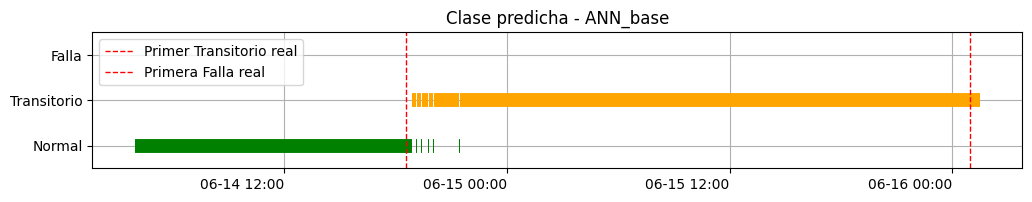

In [37]:
#timeline in predicted test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates # Import mdates for date formatting

# Map categorical labels to numerical values (This step is incorrect and will be removed)
# y_pred_test_series = pd.Series(y_pred, index=y_test.index)
# y_num = y_pred_test_series.map({'Normal': 0, 'Transitorio': 1, 'Falla': 2})

# Use the integer predicted labels directly
y_num = pd.Series(y_pred, index=y_test.index).astype(int)


# Identify where the class changes
class_changes = y_num[y_num.diff() != 0]

# Create segments
segments = []
if not class_changes.empty:
    # First segment starts at the beginning of the series
    segments.append({'start': y_num.index[0], 'end': class_changes.index[0], 'class': y_num.iloc[0]})

    # Intermediate segments
    for i in range(len(class_changes) - 1):
        segments.append({
            'start': class_changes.index[i],
            'end': class_changes.index[i+1],
            'class': class_changes.iloc[i]
        })

    # Last segment starts at the last change point and ends at the end of the series
    segments.append({'start': class_changes.index[-1], 'end': y_num.index[-1], 'class': class_changes.iloc[-1]})
else:
    # If no class changes, the whole series is one segment
    if not y_num.empty:
        segments.append({'start': y_num.index[0], 'end': y_num.index[-1], 'class': y_num.iloc[0]})


fig, ax = plt.subplots(figsize=(12, 2)) # Adjust figure size as needed

# Define y-axis positions and colors for each class
y_positions = {0: 0, 1: 1, 2: 2}
class_colors = {0: 'green', 1: 'orange', 2: 'blue'} # Define colors for clarity
class_labels = {0: 'Normal', 1: 'Transitorio', 2: 'Falla'} # Define labels for legend

# Plot horizontal lines for each segment
for segment in segments:
    start_time = segment['start']
    end_time = segment['end']
    class_value = segment['class']
    y_pos = y_positions[class_value]
    color = class_colors[class_value]
    label = class_labels[class_value]

    # Plot a horizontal line for the segment
    ax.hlines(y_pos, start_time, end_time, color=color, lw=10) #lw line widht

first_transitorio_test = y_test[y_test == 1].index[0] # Updated to use integer label 1
first_falla_test = y_test[y_test == 2].index[0]
ax.axvline(x=first_transitorio_test, color='red', linestyle='--', linewidth=1, label = 'Primer Transitorio real')
ax.axvline(x=first_falla_test, color='red', linestyle='--', linewidth=1, label = 'Primera Falla real')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
#ax.set_xticklabels(ticklabels, fontsize=8);

#ax.set_ylabel("Class")
ax.set_title("Clase predicha - ANN_base")

# Set y-axis ticks and labels
ax.set_yticks([y_positions[0], y_positions[1], y_positions[2]])
ax.set_yticklabels(["Normal", "Transitorio", "Falla"])
ax.set_ylim(-0.5,2.5)

# Improve x-axis tick formatting for dates
fig.autofmt_xdate() # Auto-format date labels for better readability

# Add a legend - ensure unique labels are used for the legend
handles, labels = ax.get_legend_handles_labels()
# Create a dictionary to store unique handles and labels
unique_labels = dict(zip(labels, handles))

plt.legend(loc = 'upper left')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

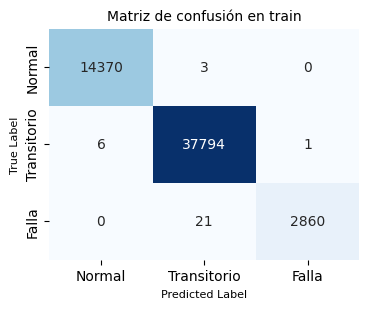

In [38]:
#Matriz de confusion con train
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Import confusion_matrix here

y_true = y_train
#y_pred = y_pred_train

y_pred_probs = y_predicted_train # Rename for clarity

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2]) # Use integer labels

# heatmap
plt.figure(figsize=(4, 3)) # Optional: Adjust figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Transitorio', 'Falla'],
            yticklabels=['Normal', 'Transitorio', 'Falla'])
plt.xlabel('Predicted Label', fontsize = 8)
plt.ylabel('True Label', fontsize = 8)
plt.title('Matriz de confusión en train', fontsize = 10)
plt.show()

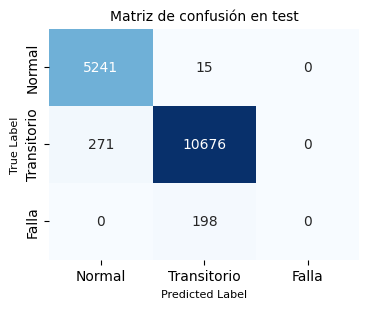

In [39]:
#Matriz de confusion con test
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Import confusion_matrix here

y_true = y_test
#y_pred = y_pred_train

y_pred_probs = y_predicted_test # Rename for clarity

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2]) # Use integer labels

# heatmap
plt.figure(figsize=(4, 3)) # Optional: Adjust figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Transitorio', 'Falla'],
            yticklabels=['Normal', 'Transitorio', 'Falla'])
plt.xlabel('Predicted Label', fontsize = 8)
plt.ylabel('True Label', fontsize = 8)
plt.title('Matriz de confusión en test', fontsize = 10)
plt.show()